In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
# dataset prep
batch_size = 64

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 460545125.94it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 57656208.39it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 162063349.97it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 21672956.51it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [5]:
class CNNModel1(nn.Module):
  def __init__(self):
    super(CNNModel1, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(128*3*3, 128)
    self.dense2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool3(x)
    x = x.view(x.shape[0], -1)
    x = self.dense1(x)
    x = self.dense2(x)
    return F.log_softmax(x, dim=1)

In [6]:
class CNNModel2(nn.Module):
  def __init__(self):
    super(CNNModel2, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(64*7*7, 128)
    self.dense2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = x.view(x.shape[0], -1)
    x = self.dense1(x)
    x = self.dense2(x)
    return F.log_softmax(x, dim=1)

In [7]:
class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dense1 = nn.Linear(32*14*14, 128)
        self.dense2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = x.view(x.shape[0], -1)
        x = self.dense1(x)
        x = self.dense2(x)
        return F.log_softmax(x, dim=1)

In [8]:

def train(model, optimizer, epochs, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    train_loss = []
    train_acc = []

    for epoch in tqdm(range(epochs)):
      correct = 0
      total_samples = 0
      batch_loss=[]
      batch_acc=[]

      for i, batch in enumerate(train_loader):
          images, labels = batch[0].to(device), batch[1].to(device)
          # Forward pass
          output = model(images)
          loss = loss_func(output, labels)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Update metrics
          predicted = torch.max(output.data, 1)[1]
          correct += (predicted == labels).sum().item()
          total_samples += labels.size(0)

          batch_loss.append(loss.item())
          batch_acc.append(correct/total_samples)

      # Calculate average loss and accuracy for the epoch
      train_loss.append(np.average(batch_loss))
      train_acc.append(np.average(batch_acc))
      print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1] * 100:.2f}%')

    return train_loss, train_acc

In [9]:
epoch = 10
model1 = CNNModel1().to(device)
model2 = CNNModel2().to(device)
model3 = CNNModel3().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)
optimizer3 = optim.Adam(model3.parameters(), lr=1e-4)
losses_model1, acc_model1 = train(model1, optimizer1, epoch, training_DataLoader)
losses_model2, acc_model2 = train(model2, optimizer2, epoch, training_DataLoader)
losses_model3, acc_model3 = train(model3, optimizer3, epoch, training_DataLoader)

 10%|█         | 1/10 [00:17<02:33, 17.03s/it]

Epoch 1/10, Loss: 0.3804, Accuracy: 75.92%


 20%|██        | 2/10 [00:32<02:08, 16.12s/it]

Epoch 2/10, Loss: 0.0867, Accuracy: 97.13%


 30%|███       | 3/10 [00:47<01:50, 15.77s/it]

Epoch 3/10, Loss: 0.0609, Accuracy: 98.04%


 40%|████      | 4/10 [01:03<01:33, 15.61s/it]

Epoch 4/10, Loss: 0.0473, Accuracy: 98.52%


 50%|█████     | 5/10 [01:19<01:18, 15.73s/it]

Epoch 5/10, Loss: 0.0399, Accuracy: 98.76%


 60%|██████    | 6/10 [01:34<01:02, 15.62s/it]

Epoch 6/10, Loss: 0.0331, Accuracy: 98.98%


 70%|███████   | 7/10 [01:52<00:48, 16.30s/it]

Epoch 7/10, Loss: 0.0293, Accuracy: 99.14%


 80%|████████  | 8/10 [02:07<00:32, 16.09s/it]

Epoch 8/10, Loss: 0.0258, Accuracy: 99.22%


 90%|█████████ | 9/10 [02:23<00:15, 15.84s/it]

Epoch 9/10, Loss: 0.0224, Accuracy: 99.36%


100%|██████████| 10/10 [02:38<00:00, 15.84s/it]


Epoch 10/10, Loss: 0.0198, Accuracy: 99.40%


 10%|█         | 1/10 [00:15<02:19, 15.52s/it]

Epoch 1/10, Loss: 0.3004, Accuracy: 83.03%


 20%|██        | 2/10 [00:30<01:59, 14.94s/it]

Epoch 2/10, Loss: 0.0868, Accuracy: 97.32%


 30%|███       | 3/10 [00:44<01:43, 14.82s/it]

Epoch 3/10, Loss: 0.0636, Accuracy: 98.04%


 40%|████      | 4/10 [00:59<01:28, 14.68s/it]

Epoch 4/10, Loss: 0.0521, Accuracy: 98.51%


 50%|█████     | 5/10 [01:14<01:14, 14.91s/it]

Epoch 5/10, Loss: 0.0448, Accuracy: 98.54%


 60%|██████    | 6/10 [01:29<00:59, 14.77s/it]

Epoch 6/10, Loss: 0.0395, Accuracy: 98.90%


 70%|███████   | 7/10 [01:43<00:44, 14.69s/it]

Epoch 7/10, Loss: 0.0354, Accuracy: 99.02%


 80%|████████  | 8/10 [01:58<00:29, 14.66s/it]

Epoch 8/10, Loss: 0.0319, Accuracy: 99.02%


 90%|█████████ | 9/10 [02:13<00:14, 14.81s/it]

Epoch 9/10, Loss: 0.0282, Accuracy: 99.16%


100%|██████████| 10/10 [02:28<00:00, 14.81s/it]


Epoch 10/10, Loss: 0.0251, Accuracy: 99.20%


 10%|█         | 1/10 [00:13<02:03, 13.77s/it]

Epoch 1/10, Loss: 0.3034, Accuracy: 86.66%


 20%|██        | 2/10 [00:27<01:49, 13.73s/it]

Epoch 2/10, Loss: 0.1226, Accuracy: 96.23%


 30%|███       | 3/10 [00:41<01:36, 13.82s/it]

Epoch 3/10, Loss: 0.0856, Accuracy: 97.43%


 40%|████      | 4/10 [00:55<01:23, 13.89s/it]

Epoch 4/10, Loss: 0.0681, Accuracy: 97.99%


 50%|█████     | 5/10 [01:09<01:10, 14.06s/it]

Epoch 5/10, Loss: 0.0580, Accuracy: 98.26%


 60%|██████    | 6/10 [01:23<00:56, 14.03s/it]

Epoch 6/10, Loss: 0.0507, Accuracy: 98.51%


 70%|███████   | 7/10 [01:37<00:41, 13.95s/it]

Epoch 7/10, Loss: 0.0463, Accuracy: 98.54%


 80%|████████  | 8/10 [01:51<00:27, 13.98s/it]

Epoch 8/10, Loss: 0.0415, Accuracy: 98.86%


 90%|█████████ | 9/10 [02:05<00:13, 13.92s/it]

Epoch 9/10, Loss: 0.0387, Accuracy: 98.97%


100%|██████████| 10/10 [02:19<00:00, 13.95s/it]

Epoch 10/10, Loss: 0.0333, Accuracy: 99.14%


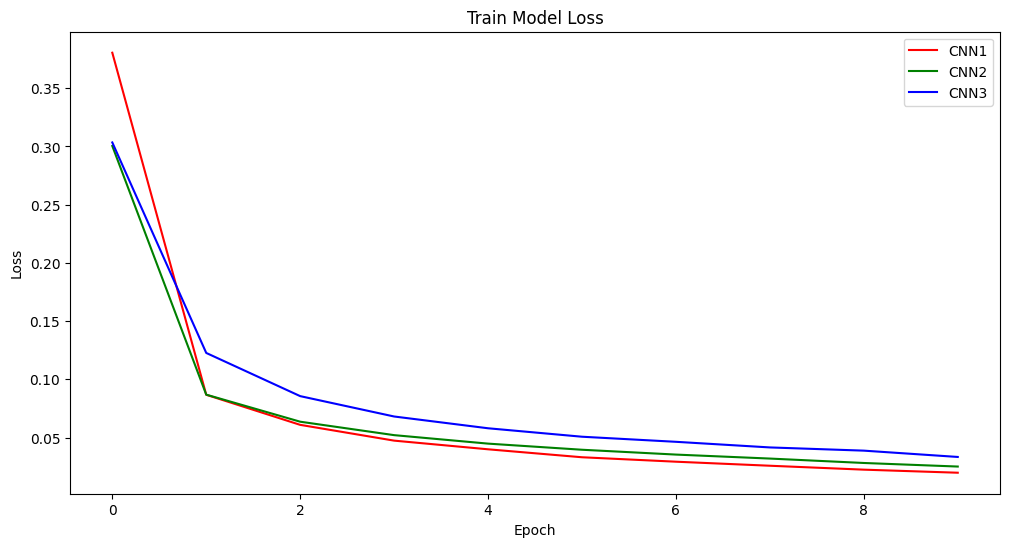

In [12]:
# Visualize Loss

plt.figure(figsize=(12, 6))
plt.plot(losses_model1, 'r-', label='CNN1')
plt.plot(losses_model2, 'g-', label='CNN2')
plt.plot(losses_model3, 'b-', label='CNN3')
plt.title('Train Model Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()




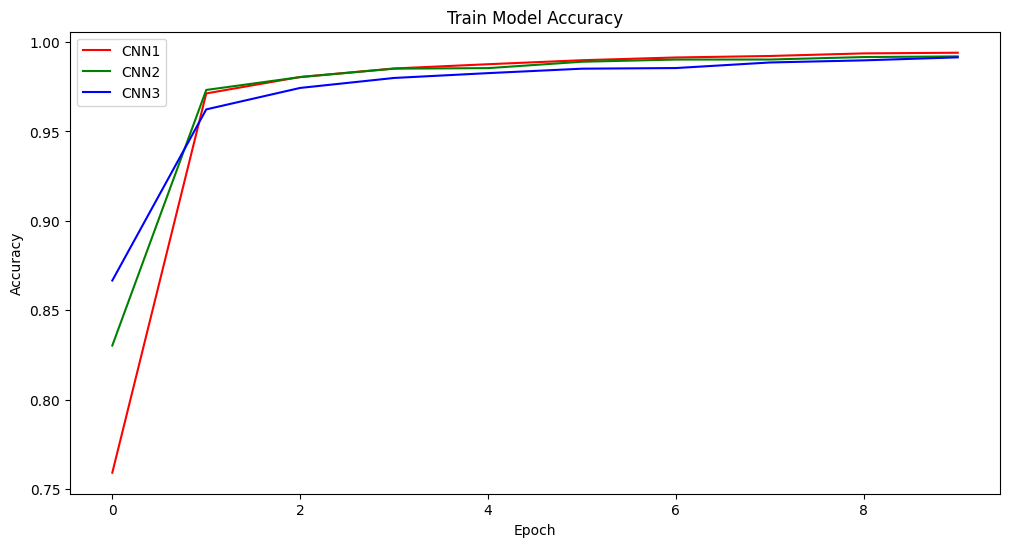

In [13]:

# Visualize Accuracy
plt.figure(figsize=(12,6))
plt.plot(acc_model1, 'r-', label='CNN1')
plt.plot(acc_model2, 'g-', label='CNN2')
plt.plot(acc_model3, 'b-', label='CNN3')
plt.title('Train Model Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()